In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.layers import Dense , Activation, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.utils import to_categorical, plot_model
import os, datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.keras import backend as K
from random import randint, seed
from datetime import datetime
K.clear_session()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_df = pd.read_csv('input/plant-pathology-2020-fgvc7/train.csv')
test_df = pd.read_csv('input/plant-pathology-2020-fgvc7/test.csv')

In [ ]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
train_df['label'] = train_df.apply(lambda x: np.argmax(x[1:]),axis=1)

In [ ]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [ ]:
from PIL import Image
img = Image.open('input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
nparr  = np.asarray(img)

In [ ]:
nparr.shape

(1365, 2048, 3)

In [ ]:
import os
label_encode = {0:"healthy",1:"multiple_diseases",2:"rust",3:"scab"}

In [ ]:
train_df.shape

(1821, 6)

In [ ]:
train_df.iloc[0]['image_id']

'Train_0'

In [ ]:
from sklearn.model_selection import train_test_split

train_df,validate_df = train_test_split(train_df,test_size=0.2)

In [ ]:
new_img_size = (224,224)

In [ ]:
img = Image.open(f'input/plant-pathology-2020-fgvc7/images/{train_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_train = np.array([np.asarray(img)])

for i in range(1,train_df.shape[0]):
    img = Image.open(f'input/plant-pathology-2020-fgvc7/images/{train_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_train = np.concatenate((images_train,np.array([np.asarray(img)])),axis=0)

In [ ]:
img = Image.open(f'input/plant-pathology-2020-fgvc7/images/{validate_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_validate = np.array([np.asarray(img)])
for i in range(1,validate_df.shape[0]):
    img = Image.open(f'input/plant-pathology-2020-fgvc7/images/{validate_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_validate = np.concatenate((images_validate,np.array([np.asarray(img)])),axis=0)

In [ ]:
img = Image.open(f'input/plant-pathology-2020-fgvc7/images/{test_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_test = np.array([np.asarray(img)])
for i in range(1,test_df.shape[0]):
    img = Image.open(f'input/plant-pathology-2020-fgvc7/images/{test_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_test = np.concatenate((images_test,np.array([np.asarray(img)])),axis=0)

In [ ]:
print("Training set is of shape : ",images_train.shape)
print("Validation set is of shape : ",images_validate.shape)
print("Test set is of shape : ",images_test.shape)

Training set is of shape :  (1456, 224, 224, 3)
Validation set is of shape :  (365, 224, 224, 3)
Test set is of shape :  (1821, 224, 224, 3)


In [ ]:
model = Sequential([
    layers.Rescaling(1./255.,input_shape=(224,224,3)),
    layers.Conv2D(8,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(4,activation='softmax'),   
])
model.build()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                    

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
batch_size = 32
epochs = 15

model.fit(
    images_train,
    train_df['label'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(images_validate,validate_df['label'])
)

Epoch 1/15
46/46 [==============================] - 43s 924ms/step - loss: 1.2419 - accuracy: 0.4038 - val_loss: 1.1573 - val_accuracy: 0.5205
Epoch 2/15
46/46 [==============================] - 42s 913ms/step - loss: 1.0529 - accuracy: 0.5536 - val_loss: 0.9210 - val_accuracy: 0.6247
Epoch 3/15
46/46 [==============================] - 43s 928ms/step - loss: 0.8449 - accuracy: 0.6724 - val_loss: 0.8449 - val_accuracy: 0.6466
Epoch 4/15
46/46 [==============================] - 42s 921ms/step - loss: 0.6882 - accuracy: 0.7225 - val_loss: 0.8052 - val_accuracy: 0.6685
Epoch 5/15
46/46 [==============================] - 42s 917ms/step - loss: 0.5497 - accuracy: 0.7830 - val_loss: 0.7533 - val_accuracy: 0.7014
Epoch 6/15
46/46 [==============================] - 42s 913ms/step - loss: 0.4018 - accuracy: 0.8420 - val_loss: 0.8933 - val_accuracy: 0.7014
Epoch 7/15
46/46 [==============================] - 42s 913ms/step - loss: 0.3566 - accuracy: 0.8578 - val_loss: 0.9902 - val_accuracy: 0.6685

In [ ]:
data_augmentation = Sequential([
    layers.RandomRotation(factor=(-0.2,0.2),seed = 123),
    layers.RandomZoom(0.1),
])

In [ ]:
model2 = Sequential([
    layers.Rescaling(1./255.,input_shape=(224,224,3)),
    data_augmentation,
    layers.Conv2D(8,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(4,activation='softmax'),   
])
model2.build()

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 111, 111, 8)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 16)      1168      
                                                      

In [ ]:
model2.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

batch_size = 32
epochs = 50

history = model2.fit(
    images_train,
    train_df['label'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(images_validate,validate_df['label'])
)

Epoch 1/50
46/46 [==============================] - 54s 1s/step - loss: 1.8575 - accuracy: 0.3118 - val_loss: 1.3209 - val_accuracy: 0.3589
Epoch 2/50
46/46 [==============================] - 53s 1s/step - loss: 1.2448 - accuracy: 0.3482 - val_loss: 1.2588 - val_accuracy: 0.3370
Epoch 3/50
46/46 [==============================] - 53s 1s/step - loss: 1.2446 - accuracy: 0.3613 - val_loss: 1.2409 - val_accuracy: 0.3562
Epoch 4/50
46/46 [==============================] - 53s 1s/step - loss: 1.2344 - accuracy: 0.3832 - val_loss: 1.2485 - val_accuracy: 0.3890
Epoch 5/50
46/46 [==============================] - 53s 1s/step - loss: 1.2389 - accuracy: 0.3558 - val_loss: 1.2578 - val_accuracy: 0.3973
Epoch 6/50
46/46 [==============================] - 53s 1s/step - loss: 1.2310 - accuracy: 0.3798 - val_loss: 1.2497 - val_accuracy: 0.4082
Epoch 7/50
46/46 [==============================] - 54s 1s/step - loss: 1.2240 - accuracy: 0.3853 - val_loss: 1.2435 - val_accuracy: 0.4274
Epoch 8/50
46/46 [==

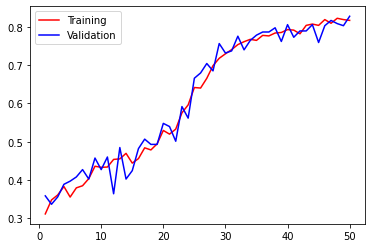

In [ ]:
train_acc = history.history['accuracy']
validate_acc = history.history['val_accuracy']
epoch_ = range(1,epochs+1)

plt.plot(epoch_,train_acc,'r',label='Training')
plt.plot(epoch_,validate_acc,'b',label='Validation')
plt.legend()
plt.show()

In [ ]:
print(train_acc)

[0.3118131756782532, 0.3482142984867096, 0.3612637221813202, 0.38324177265167236, 0.35576921701431274, 0.3798076808452606, 0.38530218601226807, 0.4038461446762085, 0.43612638115882874, 0.4333791136741638, 0.43406593799591064, 0.45398351550102234, 0.4553571343421936, 0.46978020668029785, 0.4443681240081787, 0.45604395866394043, 0.4842033088207245, 0.47870880365371704, 0.49450549483299255, 0.5295329689979553, 0.5199176073074341, 0.5329670310020447, 0.5755494236946106, 0.5961538553237915, 0.6414835453033447, 0.6401098966598511, 0.6655219793319702, 0.6984890103340149, 0.7177197933197021, 0.7293956279754639, 0.7403846383094788, 0.7534340620040894, 0.7609890103340149, 0.7671703100204468, 0.7644230723381042, 0.7774725556373596, 0.776098906993866, 0.7836538553237915, 0.7850274443626404, 0.7925823926925659, 0.791208803653717, 0.781593382358551, 0.8035714030265808, 0.8070054650306702, 0.8035714030265808, 0.8186812996864319, 0.8090659379959106, 0.8221153616905212, 0.8186812996864319, 0.8166208863

In [ ]:
print(validate_acc)

[0.3589041233062744, 0.3369863033294678, 0.3561643958091736, 0.38904109597206116, 0.39726027846336365, 0.40821918845176697, 0.4273972511291504, 0.4027397334575653, 0.4575342535972595, 0.4273972511291504, 0.46027398109436035, 0.3643835484981537, 0.48493149876594543, 0.4027397334575653, 0.42465752363204956, 0.4821917712688446, 0.5068492889404297, 0.4931506812572479, 0.4931506812572479, 0.5479452013969421, 0.5397260189056396, 0.501369833946228, 0.5917808413505554, 0.5616438388824463, 0.6657534241676331, 0.6794520616531372, 0.7041096091270447, 0.6849315166473389, 0.7561643719673157, 0.7315068244934082, 0.7369862794876099, 0.7753424644470215, 0.7397260069847107, 0.7643835544586182, 0.7780821919441223, 0.7863013744354248, 0.7863013744354248, 0.7972602844238281, 0.7616438269615173, 0.8054794669151306, 0.7726027369499207, 0.7890411019325256, 0.7890411019325256, 0.8054794669151306, 0.7589040994644165, 0.8027397394180298, 0.8164383769035339, 0.8082191944122314, 0.8027397394180298, 0.827397286891

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
print(loss)

[1.8574717044830322, 1.2448415756225586, 1.2446035146713257, 1.2343653440475464, 1.2388535737991333, 1.2310453653335571, 1.2239714860916138, 1.210936427116394, 1.2071162462234497, 1.1927932500839233, 1.1832263469696045, 1.1616848707199097, 1.1559205055236816, 1.144511103630066, 1.1546196937561035, 1.143212080001831, 1.1326850652694702, 1.1342512369155884, 1.1218242645263672, 1.085302472114563, 1.0756319761276245, 1.0623831748962402, 1.0337858200073242, 0.9963147640228271, 0.9249570369720459, 0.9080867767333984, 0.8561762571334839, 0.7796709537506104, 0.7284309267997742, 0.6734760403633118, 0.6641524434089661, 0.6375585794448853, 0.6318613290786743, 0.583491325378418, 0.590032160282135, 0.5623919367790222, 0.5560523271560669, 0.5423108339309692, 0.5405623316764832, 0.5003747940063477, 0.5179781913757324, 0.5325401425361633, 0.4996527433395386, 0.4717734158039093, 0.4933066666126251, 0.4632832109928131, 0.4631858170032501, 0.4581716060638428, 0.4387669265270233, 0.44951504468917847]


In [ ]:
print(val_loss)

[1.3209134340286255, 1.2587772607803345, 1.2408926486968994, 1.2485069036483765, 1.2577868700027466, 1.2496581077575684, 1.2435463666915894, 1.2394570112228394, 1.2046360969543457, 1.2058786153793335, 1.2279082536697388, 1.2390708923339844, 1.1879206895828247, 1.223753571510315, 1.1808204650878906, 1.1388038396835327, 1.1484040021896362, 1.1335961818695068, 1.127051830291748, 1.0802685022354126, 1.0934970378875732, 1.132536768913269, 1.023269772529602, 1.0389702320098877, 0.9064863920211792, 0.9175138473510742, 0.8746862411499023, 0.8548758029937744, 0.676459014415741, 0.7247963547706604, 0.693078339099884, 0.589370608329773, 0.6606854200363159, 0.5989998579025269, 0.5885773301124573, 0.5632332563400269, 0.540245771408081, 0.5407763123512268, 0.5943940281867981, 0.5258360505104065, 0.6177178621292114, 0.5334254503250122, 0.5315186977386475, 0.5282402634620667, 0.6036170125007629, 0.5060363411903381, 0.5076248645782471, 0.5210017561912537, 0.49204641580581665, 0.49479159712791443]


In [ ]:
!pip install -q segmentation_models

In [ ]:
model3 = tf.keras.Sequential([
        tf.keras.applications.DenseNet201(
            input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False
        ),
        GlobalAveragePooling2D(),
        Dense(4, activation='softmax')
    ])
                     
model3.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 7684      
                                                                 
Total params: 18,329,668
Trainable params: 18,100,612
Non-trainable params: 229,056
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint
ch_p_den = ModelCheckpoint(filepath="model_den.h5", monitor='val_loss', save_weights_only=True, verbose=1)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

def build_lrfn(lr_start=0.00001, lr_max=0.000075, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

history1 = model3.fit(
    images_train,
    train_df['label'], 
    epochs=10, 
    callbacks=[lr_schedule, ch_p_den],
    steps_per_epoch=32,
    validation_data=(images_validate,validate_df['label']))


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 1.4319 - accuracy: 0.2411 
Epoch 1: saving model to model_den.h5
32/32 [==============================] - 1794s 55s/step - loss: 1.4319 - accuracy: 0.2411 - val_loss: 1.4877 - val_accuracy: 0.1562 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.325e-05.
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.7837 
Epoch 2: saving model to model_den.h5
32/32 [==============================] - 1753s 55s/step - loss: 0.6750 - accuracy: 0.7837 - val_loss: 0.9308 - val_accuracy: 0.6137 - lr: 1.3250e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.65e-05.
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.9409 
Epoch 3: saving model to model_den.h5
32/32 [==============================] - 1781s 56s/step - loss: 0.3114 - accuracy: 0.9409 - val_loss: 0.

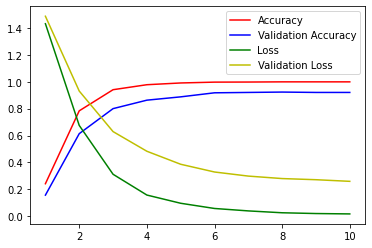

In [ ]:
train_acc3 = history1.history['accuracy']
validate_acc3 = history1.history['val_accuracy']
loss_acc4 = history1.history['loss']
validate_loss4 = history1.history['val_loss']

epoch_3 = range(1,11)

plt.plot(epoch_3,train_acc3,'r',label='Accuracy')
plt.plot(epoch_3,validate_acc3,'b',label='Validation Accuracy')
plt.plot(epoch_3,loss_acc4,'g',label='Loss')
plt.plot(epoch_3,validate_loss4,'y',label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
print(train_acc3)

[0.2410714328289032, 0.7836538553237915, 0.9409340620040894, 0.9780219793319702, 0.9910714030265808, 0.9972527623176575, 0.9979395866394043, 0.9993131756782532, 0.9993131756782532, 0.9993131756782532]


In [ ]:
print(validate_acc3)

[0.15616437792778015, 0.6136986017227173, 0.800000011920929, 0.8630136847496033, 0.8876712322235107, 0.9178082346916199, 0.9205479621887207, 0.9232876896858215, 0.9205479621887207, 0.9205479621887207]


In [ ]:
print(loss_acc4)

[1.4319267272949219, 0.6749789714813232, 0.31144973635673523, 0.15675708651542664, 0.09557889401912689, 0.05682597681879997, 0.03871229290962219, 0.024852538481354713, 0.01909658871591091, 0.016299333423376083]


In [ ]:
print(validate_loss4)

[1.4877175092697144, 0.930834949016571, 0.6290685534477234, 0.48272764682769775, 0.38589614629745483, 0.3283407986164093, 0.2978462278842926, 0.2794293761253357, 0.2709282636642456, 0.2588144838809967]


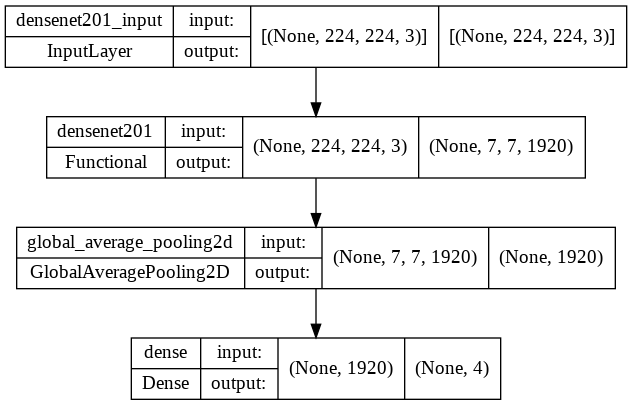

In [ ]:
plot_model(model3, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn
model4 = tf.keras.Sequential([
        efn.EfficientNetB1(
            input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False
        ),
        GlobalAveragePooling2D(),
        Dense(4, activation='softmax')
    ])
        
model4.compile(
        optimizer='adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functional  (None, 7, 7, 1280)       6575232   
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 6,580,356
Trainable params: 6,518,308
Non-trainable params: 62,048
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint
ch_p_den = ModelCheckpoint(filepath="model4_den.h5", monitor='val_loss', save_weights_only=True, verbose=1)

AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


def build_lrfn(lr_start=0.00001, lr_max=0.000075, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn


lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

history2 = model4.fit(
    images_train,
    train_df['label'], 
    epochs=10, 
    callbacks=[lr_schedule, ch_p_den],
    steps_per_epoch=32,
    validation_data=(images_validate,validate_df['label']))


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 1.4193 - accuracy: 0.2878 
Epoch 1: saving model to model4_den.h5
32/32 [==============================] - 551s 17s/step - loss: 1.4193 - accuracy: 0.2878 - val_loss: 1.6477 - val_accuracy: 0.3068 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.325e-05.
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 1.3069 - accuracy: 0.4080 
Epoch 2: saving model to model4_den.h5
32/32 [==============================] - 519s 16s/step - loss: 1.3069 - accuracy: 0.4080 - val_loss: 1.3389 - val_accuracy: 0.3370 - lr: 1.3250e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.65e-05.
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 1.1665 - accuracy: 0.5467 
Epoch 3: saving model to model4_den.h5
32/32 [==============================] - 516s 16s/step - loss: 1.1665 - accuracy: 0.5467 - val_loss: 1.

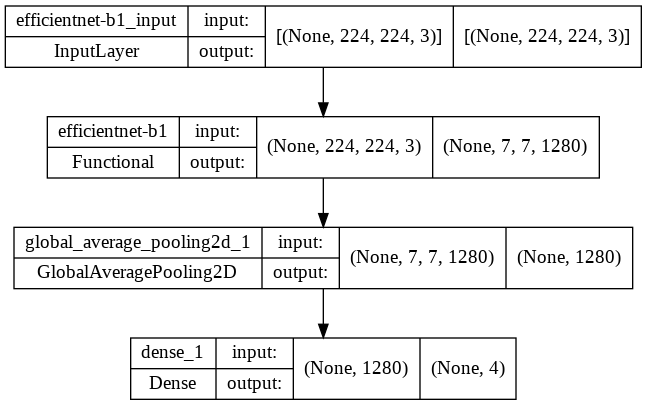

In [ ]:
plot_model(model4, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

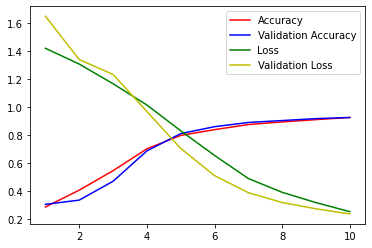

In [ ]:
train_acc5 = history2.history['accuracy']
validate_acc5 = history2.history['val_accuracy']
loss_acc6 = history2.history['loss']
validate_loss6 = history2.history['val_loss']

epoch_3 = range(1,11)

plt.plot(epoch_3,train_acc5,'r',label='Accuracy')
plt.plot(epoch_3,validate_acc5,'b',label='Validation Accuracy')
plt.plot(epoch_3,loss_acc6,'g',label='Loss')
plt.plot(epoch_3,validate_loss6,'y',label='Validation Loss')
plt.legend()
plt.show()

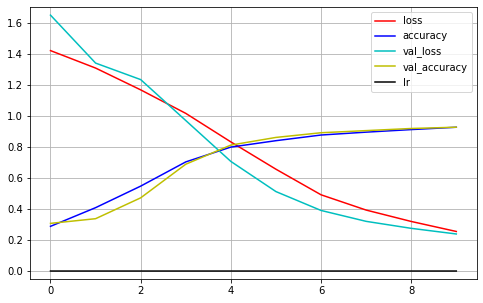

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history2.history).plot(figsize=(8, 5),color='rbcyk')
plt.grid(True)
plt.gca().set_ylim(-0.05, 1.70)
plt.show()

In [ ]:
print(train_acc5)
print(validate_acc5)
print(loss_acc6)
print(validate_loss6)

[0.2877747118473053, 0.4079670310020447, 0.5467032790184021, 0.7026098966598511, 0.7980769276618958, 0.8392857313156128, 0.8756868243217468, 0.8942307829856873, 0.9107142686843872, 0.9258241653442383]
[0.30684930086135864, 0.3369863033294678, 0.47123289108276367, 0.6876712441444397, 0.8109589219093323, 0.8602739572525024, 0.8904109597206116, 0.9041095972061157, 0.9178082346916199, 0.9260274171829224]
[1.4192984104156494, 1.3068662881851196, 1.1664990186691284, 1.0151256322860718, 0.8313315510749817, 0.6556117534637451, 0.4908837676048279, 0.39254865050315857, 0.3192005753517151, 0.25470656156539917]
[1.6477110385894775, 1.3389166593551636, 1.2325763702392578, 0.9691392183303833, 0.7056658864021301, 0.5115345120429993, 0.3900446593761444, 0.31990718841552734, 0.2749044895172119, 0.23853881657123566]


Models | Training Accuracy | Validation Accuracy | Training Time | Training Loss | Validation Loss |
-|-|-|-|-|-|
Base Model w/Aug |***0.8166*** | ***0.8274*** | ***2663 s*** | ***0.4495*** | ***0.4948*** |
EfficientNetB1 |***0.9258*** | ***0.9260***|***5248 s*** |***0.2547*** |***0.2385*** |
DenseNet201 |***0.9993*** |***0.9205*** | ***18345 s***| ***0.0163*** |***0.2588*** |